# Intorduction to Convolutional Neural Networks and Computer Vision
computer vision is the practive of writing algorithms that can discover patterns in visual data. such as the camera of a self driving car recognizing the car in front.

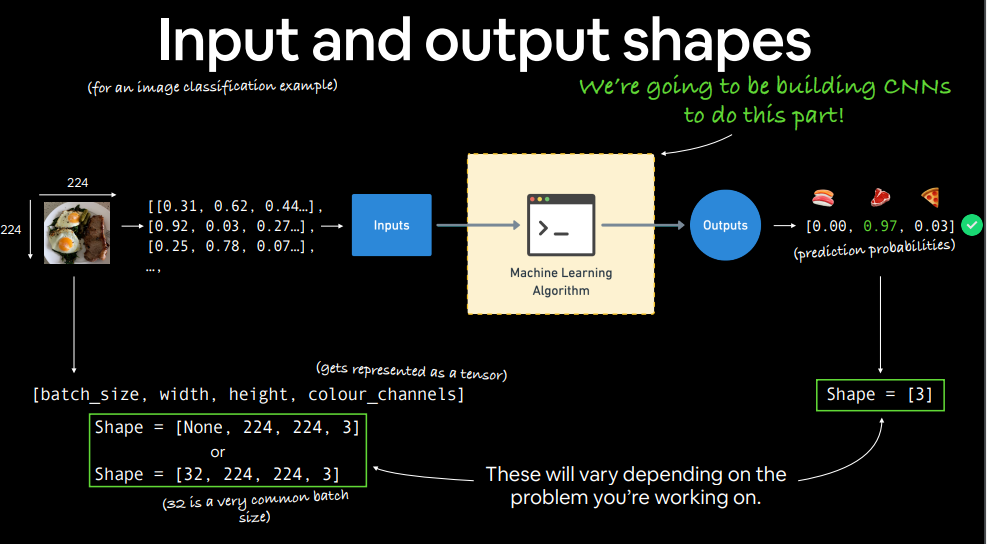

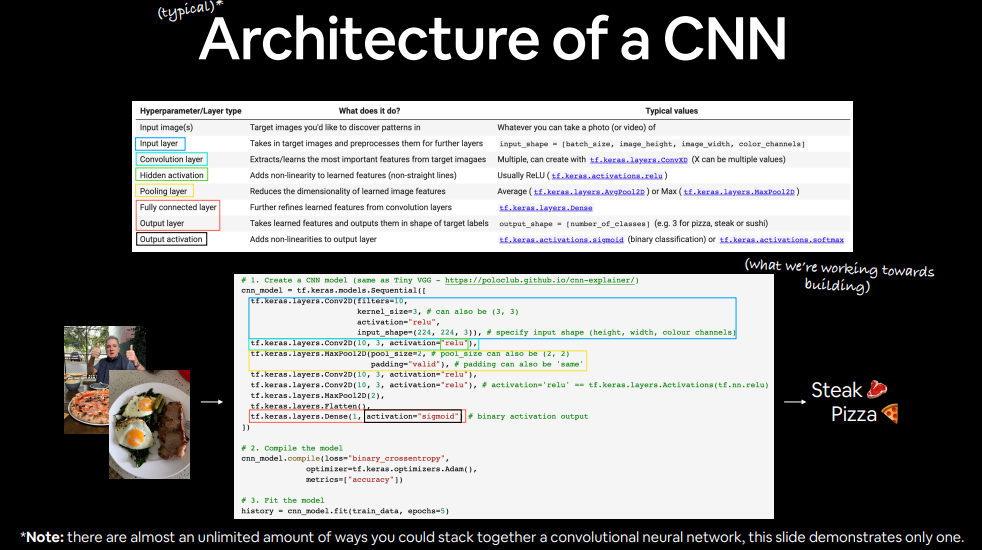

data sets can be found in ./datasets/pizza_steak or ./datasets/10_food_classes_all_data which is split into a format similar to below

* test
    * pizza
    * steak
* train
    * pizza
    * steak

#### Becoming One With The Data

a very crucial step at the beginning of any ml project is becoming one with the data. and for a computer vision project... this usually means visualizing many samples of the data.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
import random

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
for dirpath, dirnames, filenames in os.walk('./datasets/pizza_steak/'):
    print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

there are 2 directories and 0 images in ./datasets/pizza_steak/.
there are 2 directories and 0 images in ./datasets/pizza_steak/test.
there are 0 directories and 250 images in ./datasets/pizza_steak/test\pizza.
there are 0 directories and 250 images in ./datasets/pizza_steak/test\steak.
there are 2 directories and 0 images in ./datasets/pizza_steak/train.
there are 0 directories and 750 images in ./datasets/pizza_steak/train\pizza.
there are 0 directories and 750 images in ./datasets/pizza_steak/train\steak.


to viz our images first lets get the class names programmatically.

In [5]:
import pathlib
import numpy as np
data_dir = pathlib.Path('./datasets/pizza_steak/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

In [6]:
class_names

array(['pizza', 'steak'], dtype='<U5')

vis our images

In [78]:
def view_random(target_dir, target_class):
    target_folder = os.path.join(target_dir, target_class)
    print(target_folder)
    random_img = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(os.path.join(target_folder, random_img[0]))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    plt.show()
    print(f'image shape: {img.shape}')
    return img

datasets/pizza_steak/train\steak


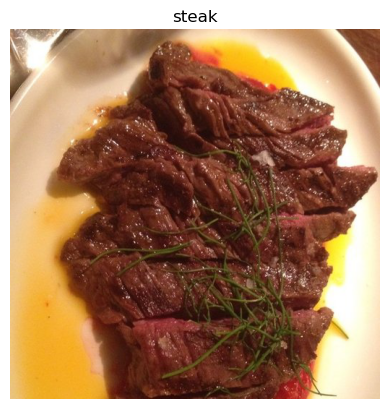

image shape: (512, 512, 3)


In [79]:
img = view_random('datasets/pizza_steak/train', 'steak')

In [9]:
tf.constant(img)

<tf.Tensor: shape=(287, 512, 3), dtype=uint8, numpy=
array([[[12, 33, 26],
        [12, 33, 26],
        [14, 35, 28],
        ...,
        [25, 42, 50],
        [22, 39, 47],
        [18, 35, 43]],

       [[13, 32, 26],
        [15, 34, 28],
        [18, 37, 31],
        ...,
        [21, 38, 46],
        [18, 35, 43],
        [15, 32, 40]],

       [[15, 34, 28],
        [14, 33, 27],
        [14, 33, 27],
        ...,
        [16, 35, 42],
        [15, 34, 41],
        [13, 32, 39]],

       ...,

       [[55, 27,  5],
        [54, 26,  4],
        [55, 27,  3],
        ...,
        [ 4,  8, 20],
        [ 4,  8, 20],
        [ 4,  8, 20]],

       [[56, 28,  7],
        [55, 27,  5],
        [57, 29,  7],
        ...,
        [ 4,  8, 20],
        [ 3,  7, 19],
        [ 3,  7, 19]],

       [[62, 34, 13],
        [60, 32, 10],
        [61, 33, 11],
        ...,
        [ 4,  8, 20],
        [ 4,  8, 20],
        [ 4,  8, 20]]], dtype=uint8)>

lets get all the pixel values between 0 and 1 for the first step of preprocessing

In [10]:
img/255.0
#with a single image this is easy but to do all the images there's a specific tool that tf has

array([[[0.04705882, 0.12941176, 0.10196078],
        [0.04705882, 0.12941176, 0.10196078],
        [0.05490196, 0.1372549 , 0.10980392],
        ...,
        [0.09803922, 0.16470588, 0.19607843],
        [0.08627451, 0.15294118, 0.18431373],
        [0.07058824, 0.1372549 , 0.16862745]],

       [[0.05098039, 0.1254902 , 0.10196078],
        [0.05882353, 0.13333333, 0.10980392],
        [0.07058824, 0.14509804, 0.12156863],
        ...,
        [0.08235294, 0.14901961, 0.18039216],
        [0.07058824, 0.1372549 , 0.16862745],
        [0.05882353, 0.1254902 , 0.15686275]],

       [[0.05882353, 0.13333333, 0.10980392],
        [0.05490196, 0.12941176, 0.10588235],
        [0.05490196, 0.12941176, 0.10588235],
        ...,
        [0.0627451 , 0.1372549 , 0.16470588],
        [0.05882353, 0.13333333, 0.16078431],
        [0.05098039, 0.1254902 , 0.15294118]],

       ...,

       [[0.21568627, 0.10588235, 0.01960784],
        [0.21176471, 0.10196078, 0.01568627],
        [0.21568627, 0

### End to end example

lets build a cnn to find patterns in our images. more specifically we need a way to: 
* load our images
* preprocess our images
* build a cnn to find patterns
* compile our cnn
* fit the cnn to our training data

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
#set random seed
tf.random.set_seed(42)

#preprocess data (get all pixel values between 0 and 1)
#can also add addtional image preprocessing steps here
#such as rotation, flips, shear, 
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

#setup paths to data directories
train_dir = './datasets/pizza_steak/train'
test_dir = './datasets/pizza_steak/test'

#import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                              batch_size = 32,
                                              target_size = (224, 224),
                                              class_mode = 'binary',
                                              seed = 42)

valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                              batch_size = 32,
                                              target_size = (224,224),
                                              class_mode = 'binary',
                                              seed = 42)

#build a cnn  (same as tinyvgg)
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 10, 
                           kernel_size = 3, 
                           activation = 'relu', 
                           input_shape = (224,224,3)),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = 2, 
                              padding = 'valid'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#compile model
model1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])


#fit the model
history1 = model1.fit(train_data, 
                      epochs = 5, 
                      steps_per_epoch = len(train_data), 
                      validation_data = valid_data,
                      validation_steps = len(valid_data))



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 11s 129ms/step - loss: 0.5664 - accuracy: 0.6833 - val_loss: 0.3576 - val_accuracy: 0.8460
Epoch 2/5
47/47 [==============================] - 5s 109ms/step - loss: 0.4180 - accuracy: 0.8133 - val_loss: 0.3404 - val_accuracy: 0.8560
Epoch 3/5
47/47 [==============================] - 5s 108ms/step - loss: 0.3912 - accuracy: 0.8287 - val_loss: 0.3159 - val_accuracy: 0.8680
Epoch 4/5
47/47 [==============================] - 5s 107ms/step - loss: 0.3478 - accuracy: 0.8553 - val_loss: 0.3018 - val_accuracy: 0.8760
Epoch 5/5
47/47 [==============================] - 5s 108ms/step - loss: 0.3093 - accuracy: 0.8773 - val_loss: 0.2790 - val_accuracy: 0.8820


In [13]:
#use batches so the images will fit into memory.

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

#### trying a non-cnn model with our images

lets replicate the model we've built in a previous section to see if it works with our image data

In [15]:
tf.random.set_seed(42)

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (224,224,3)),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history2 = model2.fit(train_data, 
                      epochs = 5, 
                      steps_per_epoch = len(train_data),
                      validation_data = valid_data,
                      validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 5s 111ms/step - loss: 1.6736 - accuracy: 0.5080 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 5s 114ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 5s 112ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 114ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 108ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [16]:
#terrible results with this non-cnn model so we'll upgrade this model so that it works better than model2

In [17]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


In [18]:
#despite having 20x more params than our cnn this model still performs terribly.

In [19]:
#lets update model2 to work better so we'll add some more layers, etc
tf.random.set_seed(42)

model3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (224,224,3)),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

history3 = model3.fit(train_data,
                     epochs = 5,
                     steps_per_epoch = len(train_data),
                     validation_data = valid_data,
                     validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 5s 112ms/step - loss: 2.7307 - accuracy: 0.6380 - val_loss: 1.1037 - val_accuracy: 0.6340
Epoch 2/5
47/47 [==============================] - 5s 108ms/step - loss: 0.6583 - accuracy: 0.7200 - val_loss: 0.5786 - val_accuracy: 0.7360
Epoch 3/5
47/47 [==============================] - 5s 108ms/step - loss: 0.8110 - accuracy: 0.7000 - val_loss: 0.6017 - val_accuracy: 0.7740
Epoch 4/5
47/47 [==============================] - 5s 108ms/step - loss: 0.5979 - accuracy: 0.7540 - val_loss: 0.5740 - val_accuracy: 0.7500
Epoch 5/5
47/47 [==============================] - 5s 109ms/step - loss: 0.5505 - accuracy: 0.7593 - val_loss: 0.8401 - val_accuracy: 0.5500


the results are quite a bit better than model2 but still nowhere near model1 (our cnn) despite having 15 million params. (our cnn only had 31,000 params)

In [20]:
model3.summary()  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


## Binary Classification: Let's break it down

1. become one with the data (viz, viz, viz)
2. preprocess the data (prepared it for our model, the main step here was scaling/normalizing)
3. created a model (start with a baseline. in our case the food101 white paper to set a benchmark)
4. fit the model
5. eval the model
6. adjust different params and improve the model (try to beat the baseline)
7. repeat until satisfied.

#### 1) Becoming 1 with the data
A CNN seeks to sort out the most important patterns in an image. even though there are less trainable params in our cnn, the model performs quite a bit better at deciphering between different features in an image.

datasets/pizza_steak/train/steak


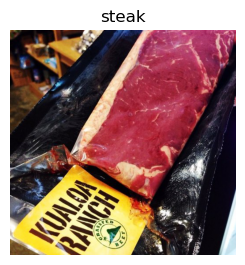

image shape: (512, 512, 3)
datasets/pizza_steak/train/pizza


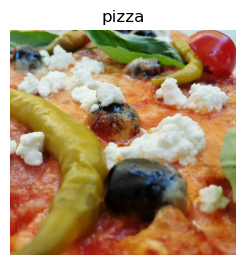

image shape: (512, 512, 3)


In [92]:
#vis the data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random('datasets/pizza_steak/train/', 'steak')
plt.subplot(1,2,2)
pizza_img = view_random('datasets/pizza_steak/train/', 'pizza')

#### 2) Preparing to load our data

1. turn all our data into numbers
2. make sure all the tensors are the right shape
3. scale features (normalize or standardize, nn tend to prefer normalization)

In [22]:
# define directory datasets path
train_dir = 'datasets/pizza_steak/train/'
test_dir = 'datasets/pizza_steak/test/'

our next step is to turn our data into *batches*. a batch is a smaller subset of the data rather than looking at all 10k images at one time, a model might only look at 32 at a time.
It does this for a couple reasons
1. 10k images (or more) might not fit into the memory of the processor/gpu (my gpu only has 6gb)
2. trying to learn the patterns in 10k images in one hit could result in the model not being able to learn very well. Yann LeCune says no more than 32 per batch

In [23]:
#create train and test data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)
#we'll look at data augmentation params within ImageDataGenerator coming up

In [24]:
#now we need to load in the image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                              target_size = (224,224), #(height, width)
                                              class_mode = 'binary',
                                              batch_size = 32)
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                            target_size = (224,224), #(height, width)
                                            class_mode = 'binary',
                                            batch_size = 32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [25]:
#we can get a sample of the training data batch
images,labels = train_data.next()  #get the next batch of images/lables in train_data

In [26]:
len(images), len(labels), len(train_data) #len of train_data is the number of batches

(32, 32, 47)

In [27]:
#lets look at an image tensor
images[0:2], images[0].shape
#we can see the images have been scaled and converted to a 224,224,3 shaped image

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.78039

In [28]:
#view the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

#### Create the model (baseline)
A baseline is a relatively simple model or existing result that you setup when beginning a machine learning experiment. Then as you keep experimenting, you try to beat the baseline.

In [29]:
#imports that make creating a model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [30]:
#lets create the model (this weill be the baseline, a 3 layer cnn)
model4 = Sequential([
    Conv2D(filters = 10, 
           kernel_size = 3, 
           strides = 1, 
           padding = 'valid', 
           activation = 'relu', 
           input_shape = (224,224,3)),
    Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    Conv2D(10, 3, activation = 'relu'),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])


In deep learning there is almost an infinite amount of architectures you could create. so one of the best ways to get started is to start with something simple and see if it works on your data. Then introduce complexity as required (e.g. look at which current model is performing best in the field of your problem)

#### Pt 5: looking inside a Conv2D layer

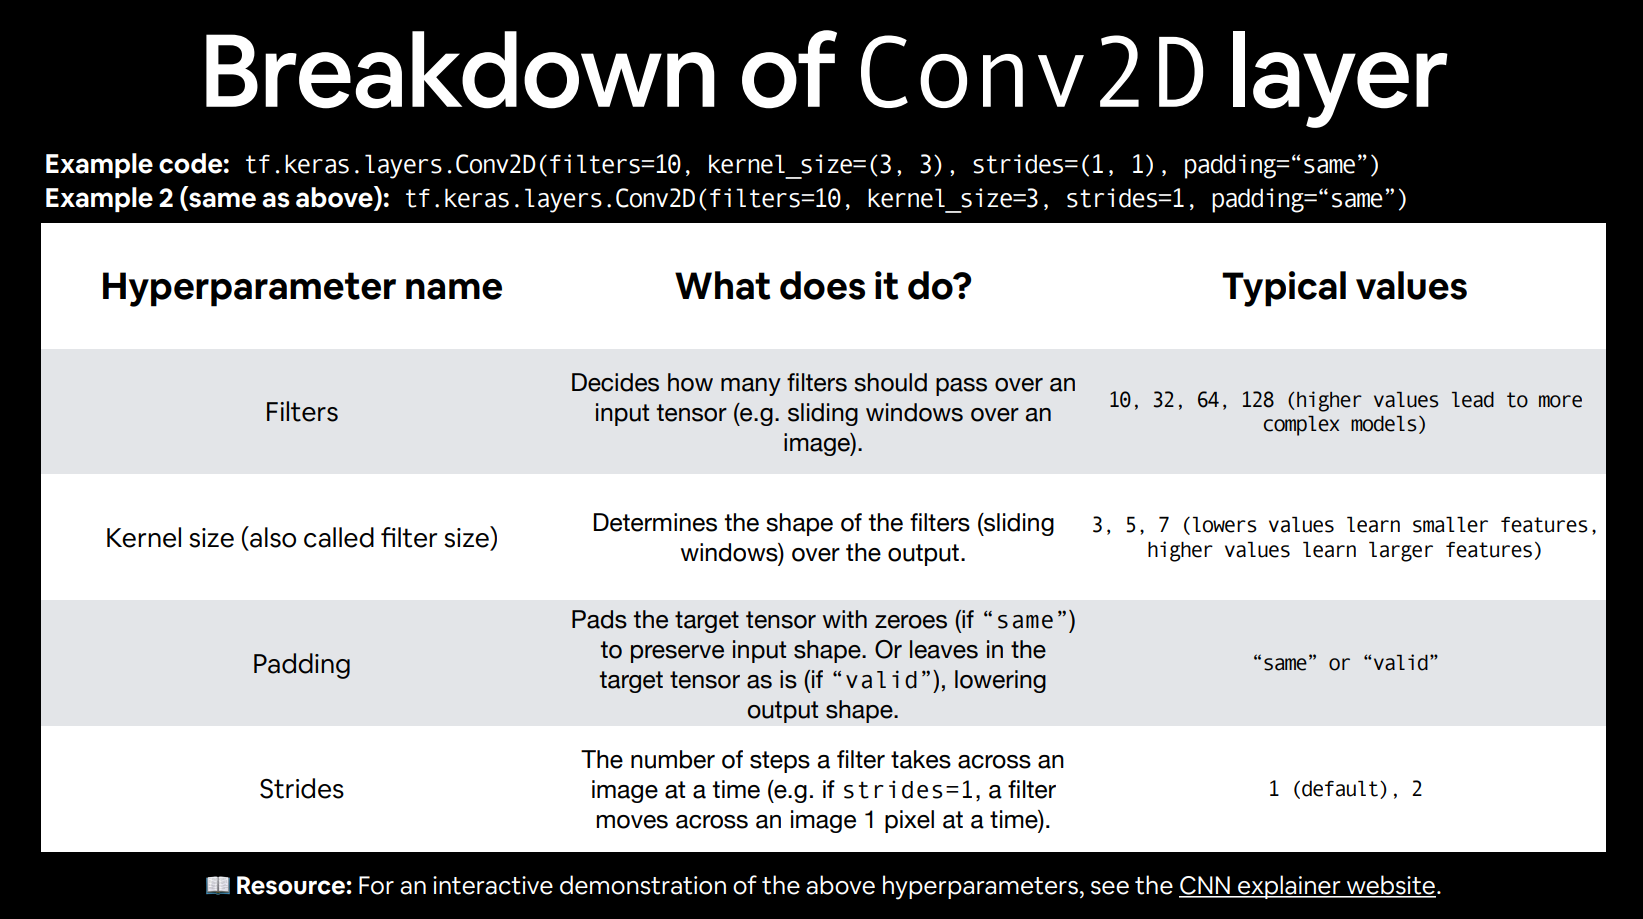

#### Pt 6: compiling and fitting the model

In [31]:
model4.compile(loss = 'binary_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

In [32]:
model4.summary()
#because padding is set to valid, each conv2d layer it goes through it loses the edges and becomes
# 1 pixel smaller on each side

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [33]:
history4 = model4.fit(train_data, #this a combo of data and labels so no need to specify x and y
           epochs = 5,
           steps_per_epoch = len(train_data),
           batch_size = 32,
           validation_data = test_data,
           validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 6s 118ms/step - loss: 1.4354 - accuracy: 0.6113 - val_loss: 0.5227 - val_accuracy: 0.7520
Epoch 2/5
47/47 [==============================] - 5s 109ms/step - loss: 0.4751 - accuracy: 0.7873 - val_loss: 0.4313 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 5s 109ms/step - loss: 0.3535 - accuracy: 0.8600 - val_loss: 0.4094 - val_accuracy: 0.8140
Epoch 4/5
47/47 [==============================] - 5s 108ms/step - loss: 0.2078 - accuracy: 0.9333 - val_loss: 0.4618 - val_accuracy: 0.7880
Epoch 5/5
47/47 [==============================] - 5s 106ms/step - loss: 0.0838 - accuracy: 0.9767 - val_loss: 0.5301 - val_accuracy: 0.7900


In [34]:
#pretty good validation accuracy but not quite as good as model1. so perhaps
#some max pooling layers will help the model improve.

#### Pt 7: evaluating on CNN's loss curves

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

<Axes: >

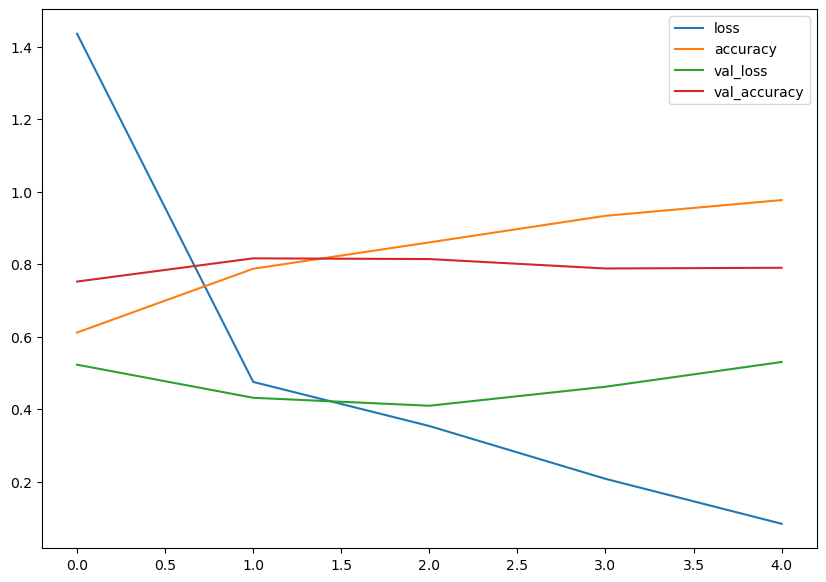

In [36]:
pd.DataFrame(history4.history).plot(figsize = (10,7))

loss of the training data starts high and continues decreasing but the loss of the validation data initially starts decreasing but eventually goes upward leading me to bgelieve the data is being overfit.

In [37]:
#plot the validation and training curves seperately
def plot_loss_curves(history):
    '''
    returns seperate loss curves for training and validation metrics
    '''
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    #plot loss
    plt.figure()
    plt.plot(epochs, loss, label = 'training loss')
    plt.plot(epochs, val_loss, label = 'val loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()
    
    #plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training accuracy')
    plt.plot(epochs, val_accuracy, label = 'val accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

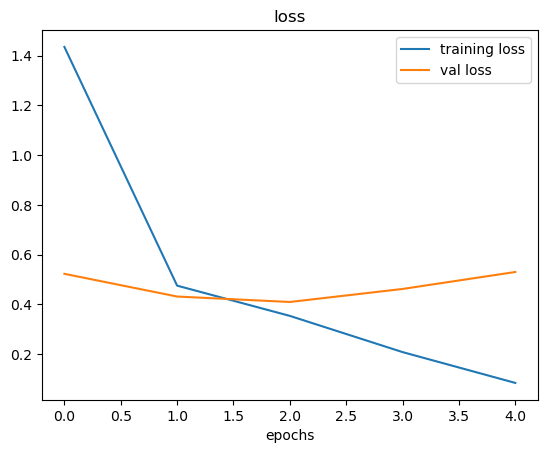

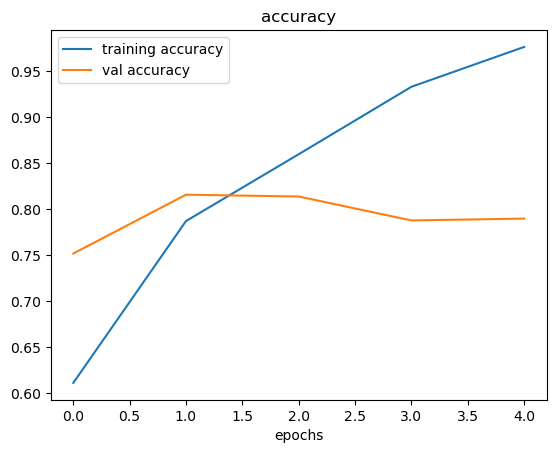

In [38]:
plot_loss_curves(history4)   
#loss curve shows overfitting
#ideally the 2 accuracy curves would be very similar to one another.

#### Pt 7: reducing overfitting with MaxPool2D layers

fitting an ml model comes in 3 steps:
1. create a baseline
2. beat the baseline by overfitting a larger model
3. reduce overfitting

ways to induce overfitting:
* increase number of conv layers
* increase the number conv filters
* add another dense layer to the output of our flattened layer


ways to reduce overfitting
* add data augmentation
* add regularization layers (such as MaxPool2D)
* add more data

In [39]:
#this is going to be our new baseline

model5 = Sequential([
    Conv2D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = (224,224,3)),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])
#by default Conv2D has a padding of 'valid' and strides of 1
#by default MaxPool2D has a pool_size of 2, padding of 'valid' and strides of None
#the output shape of MaxPool2D with default settings reduces the image size by 1/2

In [40]:
model5.compile(loss = 'binary_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])


In [41]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

In [42]:
#the maxpool layers reduce the number of total params from 477k down to 8k.

In [43]:
history5 = model5.fit(train_data,
                     epochs = 5,
                     steps_per_epoch = len(train_data),
                     validation_data = test_data,
                     validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 6s 114ms/step - loss: 0.6087 - accuracy: 0.6713 - val_loss: 0.4640 - val_accuracy: 0.7940
Epoch 2/5
47/47 [==============================] - 5s 109ms/step - loss: 0.4516 - accuracy: 0.7940 - val_loss: 0.3487 - val_accuracy: 0.8600
Epoch 3/5
47/47 [==============================] - 5s 108ms/step - loss: 0.4060 - accuracy: 0.8147 - val_loss: 0.3289 - val_accuracy: 0.8500
Epoch 4/5
47/47 [==============================] - 5s 109ms/step - loss: 0.3837 - accuracy: 0.8380 - val_loss: 0.3317 - val_accuracy: 0.8780
Epoch 5/5
47/47 [==============================] - 5s 109ms/step - loss: 0.3696 - accuracy: 0.8393 - val_loss: 0.3092 - val_accuracy: 0.8820


In [44]:
#val accuracy isn't great but improved about 4%

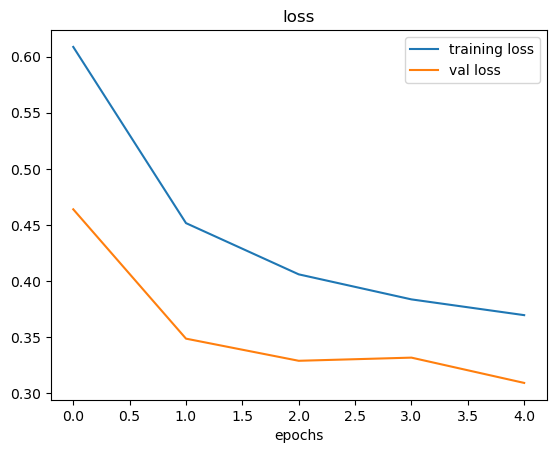

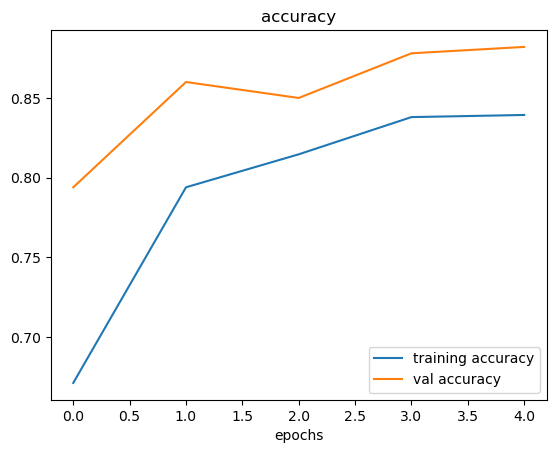

In [45]:
plot_loss_curves(history5)   


#### Pt 8: Reduce overfitting with data augmentation

Data aug is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting rotation, flipping, cropping, or something similar.


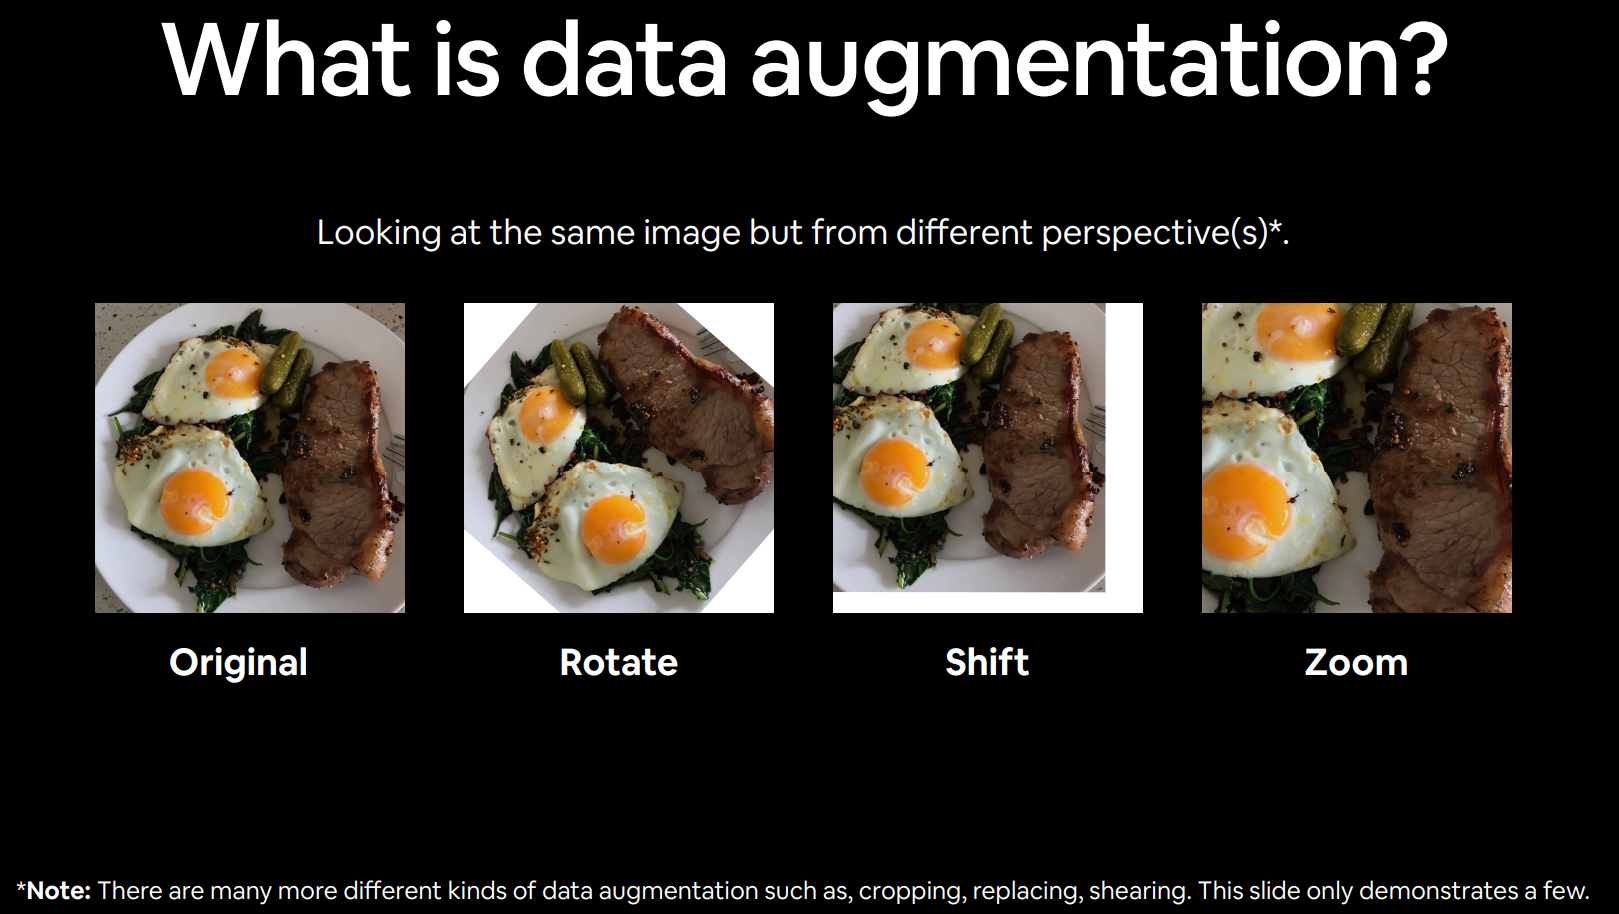

In [46]:
#create imagedatagenerator instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale = 1./255.,
                                            rotation_range = 0.2,
                                            shear_range = 0.2,
                                            zoom_range = 0.2,
                                            height_shift_range = 0.2,
                                            horizontal_flip = True)

#create imagedatagen without aumentation
train_datagen = ImageDataGenerator(rescale = 1./255.)

#create idg without aug
test_datagen = ImageDataGenerator(rescale = 1./255.)



In [47]:
print('augmented training data')
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size = (224,224),
                                                                  batch_size = 32,
                                                                  class_mode = 'binary',
                                                                  shuffle = False) 

#create non aug train data batches
print('non aug training data')
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = 'binary', 
                                              shuffle = False)

#create non aug test data batches
#data aug is only performed on the training data
print('non aug test data')
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'binary')

augmented training data
Found 1500 images belonging to 2 classes.
non aug training data
Found 1500 images belonging to 2 classes.
non aug test data
Found 500 images belonging to 2 classes.


Data aug is only performed on the training data. using imagedatagenerator build in data aug params our images are left as they are in the directories but are modified as they're loaded into the model


lets visualize some augmented data

In [48]:
#get some sample data
images, labels = train_data.next()
aug_images, aug_labels = train_data_augmented.next()

17


(-0.5, 223.5, 223.5, -0.5)

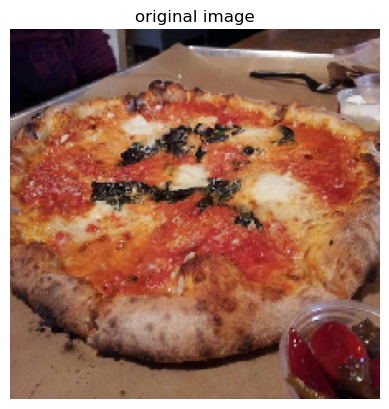

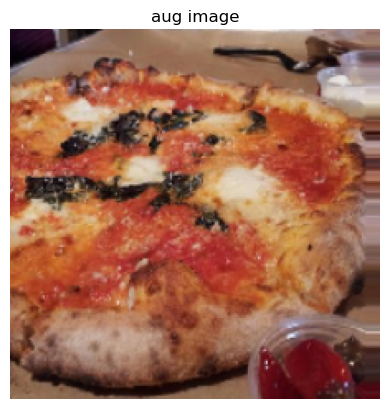

In [49]:
#show original image and augmented image
import random
random_number = random.randint(0, 31) #our batch sizes are 32
print(random_number)
plt.figure()
plt.imshow(images[random_number])
plt.title('original image')
plt.axis(False)
plt.figure()
plt.imshow(aug_images[random_number])
plt.title('aug image')
plt.axis(False)

#### Pt 11: training a cnn on augmented data

now we've seen what aug training data looks like lets train a model and see how it learns on that aug data

In [50]:
model6 = Sequential([
    Conv2D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = (224,224,3)),
    MaxPool2D(pool_size = 2),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])


model6.compile(loss = 'binary_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

history6 = model6.fit(train_data_augmented,
                     epochs = 5,
                     steps_per_epoch = len(train_data_augmented),
                     validation_data = test_data,
                     validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 272ms/step - loss: 0.7188 - accuracy: 0.5087 - val_loss: 0.6834 - val_accuracy: 0.5720
Epoch 2/5
47/47 [==============================] - 12s 263ms/step - loss: 0.6961 - accuracy: 0.5460 - val_loss: 0.6450 - val_accuracy: 0.6880
Epoch 3/5
47/47 [==============================] - 12s 263ms/step - loss: 0.6839 - accuracy: 0.6220 - val_loss: 0.6320 - val_accuracy: 0.7600
Epoch 4/5
47/47 [==============================] - 13s 265ms/step - loss: 0.6843 - accuracy: 0.6607 - val_loss: 0.6220 - val_accuracy: 0.6140
Epoch 5/5
47/47 [==============================] - 12s 263ms/step - loss: 0.6162 - accuracy: 0.6747 - val_loss: 0.5111 - val_accuracy: 0.8040


things to know, the data aug actually takes quite a bit longer to run because it has some image preprocessing to do before hand.

model6 actually performs quite a bit worse than model5, despite using data augmentation. This is because we have shuffle set to false in the train_data and train_data_aug.
We'll actually rerun those with shuffle = True to see how much better shuffling performs.

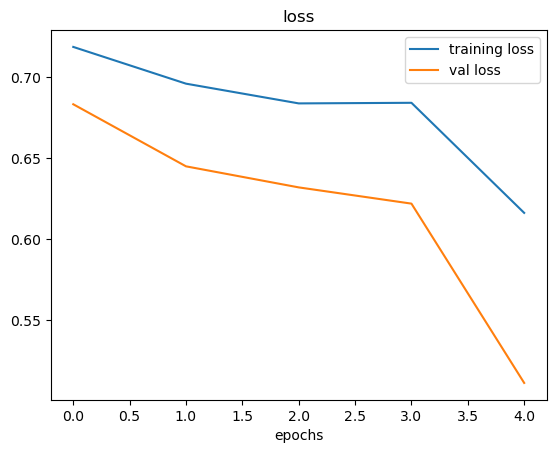

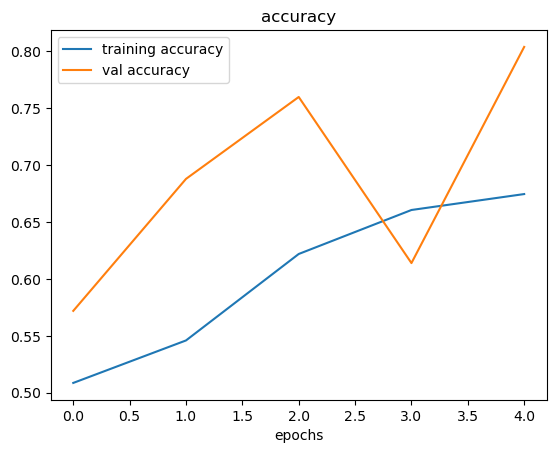

In [51]:
# lets check the training curves
plot_loss_curves(history6)

#### Pt 12: Discovering the power of shuffling the data

In [52]:
print('augmented shuffled training data')
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size = (224,224),
                                                                  batch_size = 32,
                                                                  class_mode = 'binary',
                                                                  shuffle = True) 



augmented shuffled training data
Found 1500 images belonging to 2 classes.


In [53]:
#create the model same as model5 and model6

model7 = Sequential([
    Conv2D(10, 3, activation = 'relu', input_shape = (224,224,3)),
    MaxPool2D(),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model7.compile(loss = 'binary_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

history7 = model7.fit(train_data_augmented_shuffled,
          epochs = 5,
          steps_per_epoch = len(train_data_augmented_shuffled),
          validation_data = test_data,
          validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 269ms/step - loss: 0.6069 - accuracy: 0.6633 - val_loss: 0.4412 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 12s 264ms/step - loss: 0.5100 - accuracy: 0.7493 - val_loss: 0.4068 - val_accuracy: 0.8220
Epoch 3/5
47/47 [==============================] - 12s 264ms/step - loss: 0.4608 - accuracy: 0.7900 - val_loss: 0.3484 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 12s 265ms/step - loss: 0.4441 - accuracy: 0.7993 - val_loss: 0.3315 - val_accuracy: 0.8660
Epoch 5/5
47/47 [==============================] - 12s 264ms/step - loss: 0.4377 - accuracy: 0.8080 - val_loss: 0.3331 - val_accuracy: 0.8620


Just adding the shuffle increases val accuracy a lot (from 55% to 84%.)

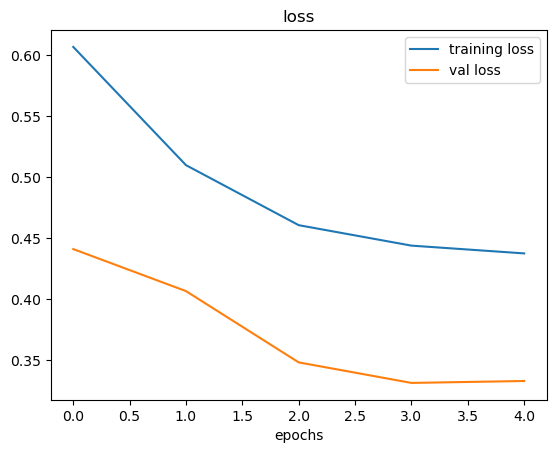

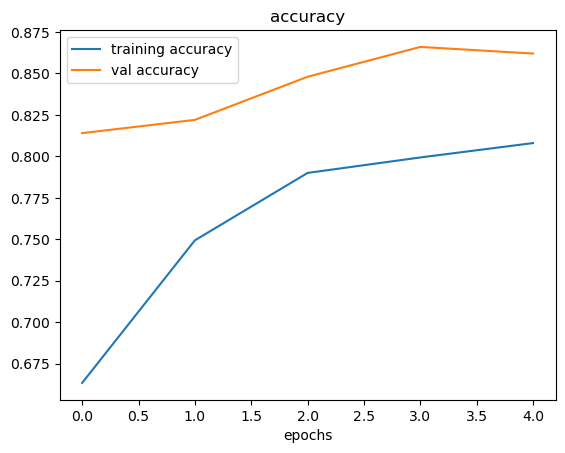

In [54]:
plot_loss_curves(history7)

Loss curves look much better, as well

When shuffling training data, the model gets exposed to all different kinds of data during training, thus enabling it to learn features across a wide array of images (in our case, pizza and steak at the same time instead of just pizza then just steak)

#### Pt 13: Exploring options to improve the model
since we've already beaten our baseline there's a few more things we could try to continue to improve our model

* adding layers (more conv2d / maxpool2d layers)
* increase the number of filters in each conv2d layer (10 to 32 or 64)
* train for longer
* find an ideal learning rate
* get more data (give the model more opportunities to learn)
* use transfer learning to leverage what another image model has learned and adjust it for our own use case

In [70]:
# recreate the cnn explainer model with augmented data

train_dir = 'datasets/pizza_steak/train/'
test_dir = 'datasets/pizza_steak/test/'

train_datagen_final = ImageDataGenerator(rescale = 1./255.,
                                        rotation_range = 0.2,
                                        horizontal_flip = True,
                                        shear_range = 0.2,
                                        height_shift_range = 0.2,
                                        width_shift_range = 0.2,
                                        zoom_range = 0.2)

test_datagen_final = ImageDataGenerator(rescale = 1./255.)



train_data_final = train_datagen_final.flow_from_directory(train_dir,
                                                          target_size = (224,224),
                                                          batch_size = 32,
                                                          class_mode = 'binary',
                                                          shuffle = True)

test_data_final = test_datagen_final.flow_from_directory(test_dir,
                                                        target_size = (224,224),
                                                        class_mode = 'binary',
                                                        shuffle = True)




model7_final = Sequential([
    Conv2D(32, 3, input_shape = (224,224,3), activation = 'relu'),
    Conv2D(32,3, activation = 'relu'),
    MaxPool2D(2),
    Conv2D(32,3, activation = 'relu'),
    Conv2D(32, 3, activation = 'relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model7_final.compile(loss = 'binary_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

model7_final.fit(train_data_final,
           epochs = 5,
           steps_per_epoch = len(train_data_final),
           validation_data = test_data_final,
           validation_steps = len(test_data_final))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 13s 269ms/step - loss: 0.6560 - accuracy: 0.6227 - val_loss: 0.5271 - val_accuracy: 0.7300
Epoch 2/5
47/47 [==============================] - 13s 267ms/step - loss: 0.5595 - accuracy: 0.7167 - val_loss: 0.4031 - val_accuracy: 0.8440
Epoch 3/5
47/47 [==============================] - 13s 266ms/step - loss: 0.5114 - accuracy: 0.7533 - val_loss: 0.4657 - val_accuracy: 0.7640
Epoch 4/5
47/47 [==============================] - 13s 268ms/step - loss: 0.5149 - accuracy: 0.7487 - val_loss: 0.3779 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 13s 266ms/step - loss: 0.4880 - accuracy: 0.7640 - val_loss: 0.3464 - val_accuracy: 0.8660


### Making a prediction with our trained model on our own custom data

In [56]:
#class we're working with
print(class_names)

['pizza' 'steak']


(-0.5, 3023.5, 4031.5, -0.5)

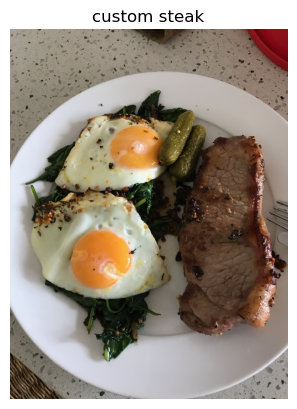

In [57]:
# get the custom image
import matplotlib.image as mpimg
steak = mpimg.imread('images/03-steak.jpeg')
plt.imshow(steak)
plt.title('custom steak')
plt.axis(False)

In [58]:
#check the shape of image
steak.shape

(4032, 3024, 3)

When you train an neural network and you want to make a prediction iwth it on your own custom data, it's important that your custom data (or new data) is preprocessed into thte same format as the data your model was trained on

In [59]:
#create a fn to import an image and resize it to match the trained model shape (224,224)
def load_and_prep(filename, img_shape = 224):
    """reads an image from filename, turns it into a tensor and reshapes 
    it to img_shape, img_shape, color channels"""
    #read in image
    img = tf.io.read_file(filename)
    #decode the read file into a tensor
    img = tf.image.decode_image(img)
    #resize image
    img = tf.image.resize(img, size = [img_shape, img_shape])
    #rescale image and get all values between 0 and 1
    img = img/255.
    return img

In [60]:
steak2 = load_and_prep('images/03-steak.jpeg')

In [61]:
steak2

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

(-0.5, 223.5, 223.5, -0.5)

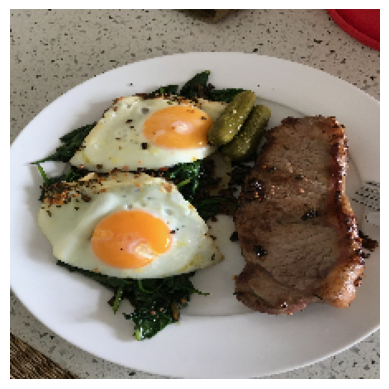

In [62]:
plt.imshow(steak2)
plt.axis(False)

In [63]:
pred = model7.predict(tf.expand_dims(steak2, axis = 0))
pred

1/1 [==============================] - 0s 155ms/step


array([[0.8339639]], dtype=float32)

Accordingm to the model there is a 78% change this is a picture of the positive class (aka steak)

In [64]:
#turn the prediction into a class name, etc
# we can index the predicted class by rounding the prediction prob and
pred_class = class_names[int(tf.round(pred))]
pred_class

'steak'

In [65]:
def pred_and_plot(model, filename, class_names = class_names):
    """imports image located at filename,
    makes a prediction with the model, and plots
    the image with the pred class"""
    #import the target image and preprocess it
    img = load_and_prep(filename)
    #make prediction
    pred = model.predict(tf.expand_dims(img, axis = 0))
    
    #get teh predicted class
    pred_class = class_names[int(tf.round(pred))]
    
    #plot imag and predicted class
    plt.imshow(img)
    plt.title(f'prediction: {pred_class}')
    plt.axis(False)

1/1 [==============================] - 0s 10ms/step


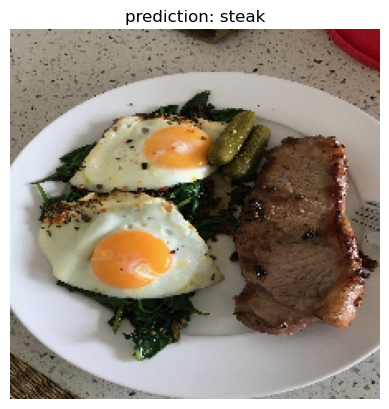

In [66]:
pred_and_plot(model7, 'images/03-steak.jpeg')

1/1 [==============================] - 0s 10ms/step


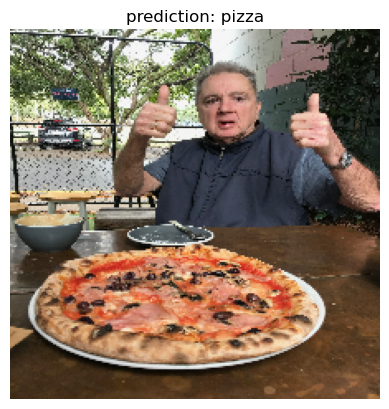

In [67]:
pred_and_plot(model7, 'images/03-pizza-dad.jpeg')

1/1 [==============================] - 0s 10ms/step


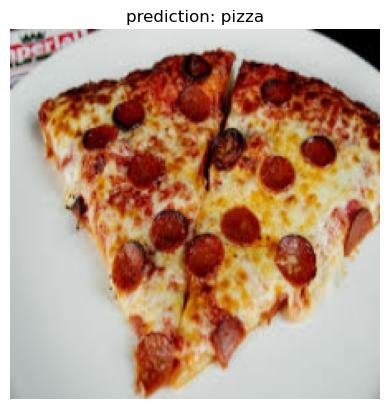

In [68]:
pred_and_plot(model7, 'images/03-pizza-online.jpg')

## Multiclass image classification

all the same steps with the binary classification but now we're doing it over multiple classes. 
1. become one with the data
2. preprocess the data (get it ready for model)
3. create a model (start with baseline)
4. fit the model (overfit it to make sure it works)
5. evaluate the model
6. adjust different hyperparms and improve the model (try to beat baseline/reduce overfitting)
7. repeat until satisfied

In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras import Sequential
import os

#### 1. become one with the data

In [73]:
#walk through 10 classes of food
for dirpath, dirnames, filenames in os.walk('datasets/10_food_classes_all_data/'):
    print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

there are 2 directories and 0 images in datasets/10_food_classes_all_data/
there are 10 directories and 0 images in datasets/10_food_classes_all_data/test
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\chicken_curry
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\chicken_wings
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\fried_rice
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\grilled_salmon
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\hamburger
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\ice_cream
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\pizza
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\ramen
there are 0 directories and 250 images in datasets/10_food_classes_all_data/test\steak
there are 0 directories 

there are 750 images for each of the food classes in train and 250 images for each class in the test directory

In [74]:
#setup train and test directories
train_dir = 'datasets/10_food_classes_all_data/train/'
test_dir = 'datasets/10_food_classes_all_data/test/'

In [80]:
#lets get class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


datasets/10_food_classes_all_data/train/steak


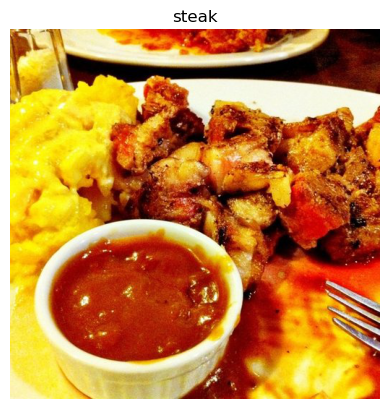

image shape: (512, 512, 3)


In [96]:
import random
img = view_random(target_dir = train_dir,
                  target_class = random.choice(class_names))

#### preprocess the data

In [113]:
train_datagen = ImageDataGenerator(rescale = 1./255.#,
                                  #rotation_range = 0.2,
                                  #height_shift_range = .2,
                                  #width_shift_range = .2,
                                  #shear_range = 0.2,
                                  #horizontal_flip = True
                                  )

test_datagen = ImageDataGenerator(rescale = 1./255.)

In [114]:
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size = (224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [115]:
image, label = train_data.next()

In [116]:
label[0], image[0]

(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[[0.43529415, 0.43921572, 0.6117647 ],
         [0.454902  , 0.46274513, 0.62352943],
         [0.45098042, 0.4666667 , 0.6156863 ],
         ...,
         [0.16078432, 0.17254902, 0.20784315],
         [0.15686275, 0.16862746, 0.20392159],
         [0.15686275, 0.16470589, 0.21176472]],
 
        [[0.43529415, 0.43921572, 0.6117647 ],
         [0.454902  , 0.46274513, 0.62352943],
         [0.45098042, 0.4666667 , 0.6156863 ],
         ...,
         [0.16078432, 0.17254902, 0.20784315],
         [0.15686275, 0.16862746, 0.20392159],
         [0.15686275, 0.16470589, 0.21176472]],
 
        [[0.43529415, 0.43921572, 0.6117647 ],
         [0.454902  , 0.46274513, 0.62352943],
         [0.45098042, 0.4666667 , 0.6156863 ],
         ...,
         [0.16078432, 0.17254902, 0.20784315],
         [0.16078432, 0.16862746, 0.21568629],
         [0.16078432, 0.16862746, 0.21568629]],
 
        ...,
 
        [[0.2392157 , 0

#### Create the model

In [117]:
model8 = Sequential([
    Conv2D(filters = 10, kernel_size = 3, input_shape = (224,224,3), activation = 'relu'),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(2),
    Conv2D(10, 3, activation = 'relu'),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(10, activation = 'softmax')
])

model8.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])


#### Fit the model

In [118]:
history8 = model8.fit(train_data,
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 25s 105ms/step - loss: 2.1132 - accuracy: 0.2371 - val_loss: 1.9429 - val_accuracy: 0.3112
Epoch 2/5
235/235 [==============================] - 24s 103ms/step - loss: 1.8715 - accuracy: 0.3441 - val_loss: 1.9044 - val_accuracy: 0.3220
Epoch 3/5
235/235 [==============================] - 24s 104ms/step - loss: 1.6317 - accuracy: 0.4480 - val_loss: 1.8112 - val_accuracy: 0.3788
Epoch 4/5
235/235 [==============================] - 24s 103ms/step - loss: 1.1041 - accuracy: 0.6321 - val_loss: 2.2306 - val_accuracy: 0.3060
Epoch 5/5
235/235 [==============================] - 25s 104ms/step - loss: 0.5061 - accuracy: 0.8447 - val_loss: 2.8558 - val_accuracy: 0.2948


In [119]:
model8.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_45 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_47 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

#### Evaluate the model

In [120]:
model8.evaluate(test_data)

79/79 [==============================] - 6s 79ms/step - loss: 2.8558 - accuracy: 0.2948


[2.855799674987793, 0.2948000133037567]

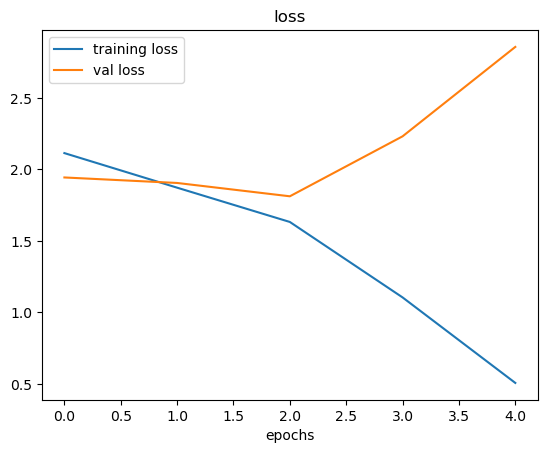

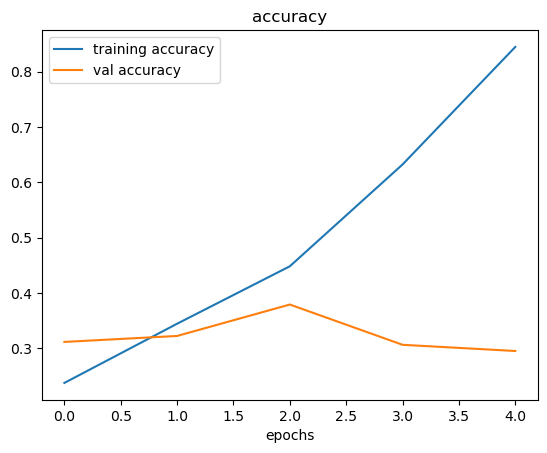

In [123]:
#check out the models loss curves
plot_loss_curves(history8)
#val loss might indicate overfitting
#accuracy also indicates our model is performing very well on data it sees but 
#generalizes very poorly

#### adjust model hyper's to beat the baseline/reduce overfitting

due to its performance on the training data, it's clear our model is learning something...
 however, it's not generalizing well to unseen data. lets try to fix overfitting by...
 * getting more data - having more data gives a model more opportunity to learn diverse patterns
 * simplify the model - if our current model is overfitting the data, it may be too complicated of a model. one way to do this is to reduce number of layers or units in layers.
 * data augmentation - data aug manipulates training data in such a way to add more diversity (without altering the original data)
 * use transfer learning 

In [127]:
#lets reduce model complexity at this point.
model9 = Sequential([
    Conv2D(filters = 10, kernel_size = 3, input_shape = (224,224,3), activation = 'relu'),
    MaxPool2D(2),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(10, activation = 'softmax')
])

model9.compile(loss = 'categorical_crossentropy',
               optimizer = Adam(),
               metrics = ['accuracy'])

history9 = model9.fit(train_data,
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 25s 104ms/step - loss: 2.1249 - accuracy: 0.2497 - val_loss: 1.9281 - val_accuracy: 0.3216
Epoch 2/5
235/235 [==============================] - 24s 103ms/step - loss: 1.7358 - accuracy: 0.4129 - val_loss: 1.9315 - val_accuracy: 0.3408
Epoch 3/5
235/235 [==============================] - 25s 106ms/step - loss: 1.2584 - accuracy: 0.5931 - val_loss: 2.1306 - val_accuracy: 0.3144
Epoch 4/5
235/235 [==============================] - 25s 107ms/step - loss: 0.7367 - accuracy: 0.7803 - val_loss: 2.5941 - val_accuracy: 0.3060
Epoch 5/5
235/235 [==============================] - 25s 107ms/step - loss: 0.3497 - accuracy: 0.9087 - val_loss: 3.0402 - val_accuracy: 0.3088


In [128]:
model9.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 29160)             0         
                                                                 
 dense_22 (Dense)            (None, 10)              

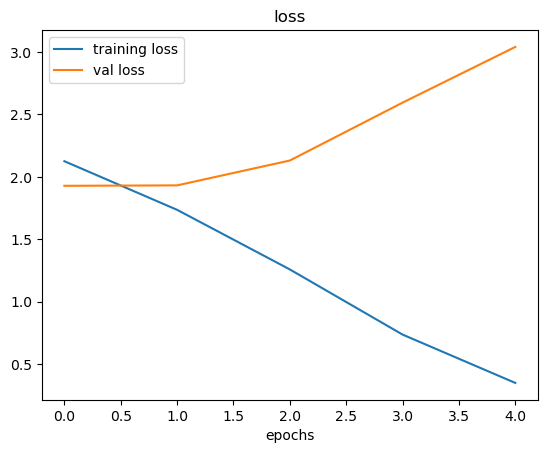

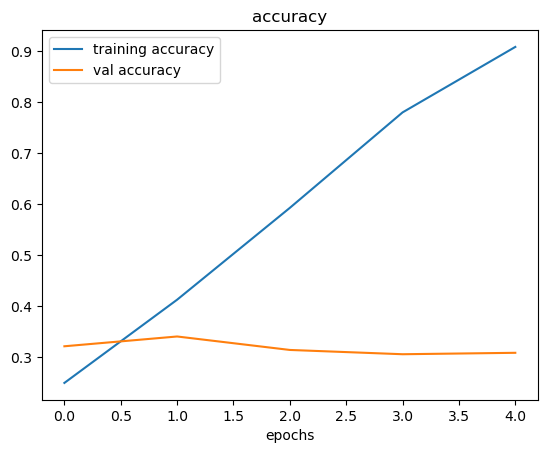

In [129]:
plot_loss_curves(history9)

this experiment did not do as well and didn't really improve val accuracy at all. Perhaps our model didn't really decrease complexity. We actually increased the number of total params in model9 even though we removed 2 conv2d layers.

#### Data augmentation to reduce overfiting

In [132]:
train_datagen_aug = ImageDataGenerator(rescale = 1./255.,
                                      height_shift_range= 0.2,
                                      width_shift_range= 0.2,
                                      rotation_range= 0.2,
                                      shear_range= 0.2,
                                      zoom_range= 0.2,
                                      horizontal_flip = True)

train_data_aug = train_datagen_aug.flow_from_directory(train_dir, 
                                                  target_size = (224,224),
                                                  batch_size=32,
                                                  class_mode = 'categorical')

Found 7500 images belonging to 10 classes.


In [134]:
model10 = tf.keras.models.clone_model(model8)  #clones model8 architecture

model10.compile(loss = 'categorical_crossentropy',
               optimizer = Adam(),
               metrics = ['accuracy'])

history10 = model10.fit(train_data_aug,
                       epochs = 5,
                       steps_per_epoch = len(train_data_aug),
                       validation_data = test_data,
                       validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 64s 273ms/step - loss: 2.2016 - accuracy: 0.1899 - val_loss: 2.0655 - val_accuracy: 0.2512
Epoch 2/5
235/235 [==============================] - 63s 268ms/step - loss: 2.0745 - accuracy: 0.2600 - val_loss: 1.9288 - val_accuracy: 0.3420
Epoch 3/5
235/235 [==============================] - 63s 270ms/step - loss: 2.0011 - accuracy: 0.3019 - val_loss: 1.8253 - val_accuracy: 0.3684
Epoch 4/5
235/235 [==============================] - 64s 273ms/step - loss: 1.9519 - accuracy: 0.3232 - val_loss: 1.7842 - val_accuracy: 0.3908
Epoch 5/5
235/235 [==============================] - 63s 269ms/step - loss: 1.9141 - accuracy: 0.3369 - val_loss: 1.8455 - val_accuracy: 0.3740


Looks like the validaiton accuracy has increased quite a bit. and also that the training accuracy has decreased down to a similar level as the validation accuracy. This indicates that the model isn't overfitting to the training data.

In [135]:
model10.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_45 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_47 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

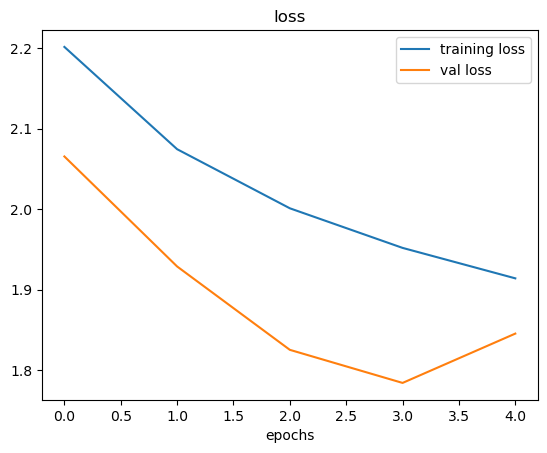

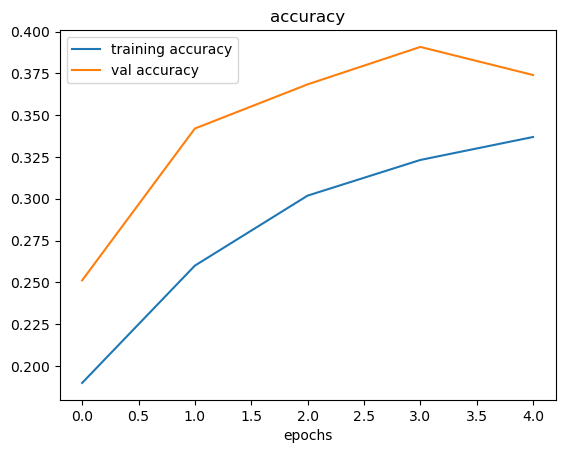

In [137]:
plot_loss_curves(history10)
#these plots indicate we have eliminated a lot of the overfitting.

perhaps we could add additonal conv2d/pooling layers to reduce the number of total params in the model

#### repeat until satisfied
we could keep going... continually trying to bring our loss curves closer together and improve validation/test accuracy.

- restructuring our model's architecture (increasing layers/hidden units)
- adjust learning rate
- try different methods of data aug (adjust hyperparams in imagedatagenerator)
- training for longer (10 epochs instead of 5)
- transfer learning

#### making a prediction on our trained model10

In [138]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [139]:
sushi = 'images/03-sushi.jpeg'
steak = 'images/03-steak.jpeg'
hamburger = 'images/03-hamburger.jpeg'
pizza = 'images/03-pizza-dad.jpeg'

In [240]:
#reconfig pred_and_plot function to work with multiclass images
def pred_and_plot(model, filename, class_names = class_names):
    """imports image located at filename,
    makes a prediction with the model, and plots
    the image with the pred class"""
    #import the target image and preprocess it
    img = load_and_prep(filename)
    #make prediction
    pred = model.predict(tf.expand_dims(img, axis = 0))
    #get teh predicted class
    pred_class = class_names[tf.math.argmax(pred, axis = 1)][0]
    #plot imag and predicted class
    plt.imshow(img)
    plt.title(f'prediction: {pred_class}')
    plt.axis(False)

1/1 [==============================] - 0s 10ms/step


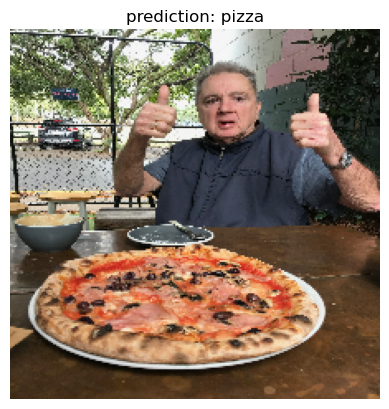

In [241]:
pred_and_plot(model10, pizza, class_names = class_names)

1/1 [==============================] - 0s 10ms/step


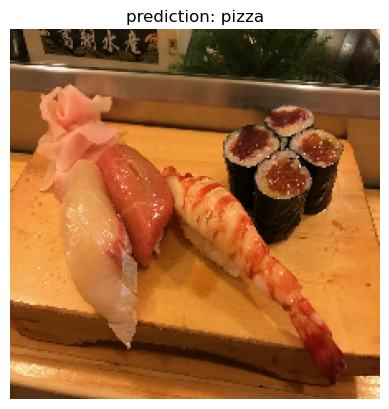

In [242]:
pred_and_plot(model10, sushi)

1/1 [==============================] - 0s 10ms/step


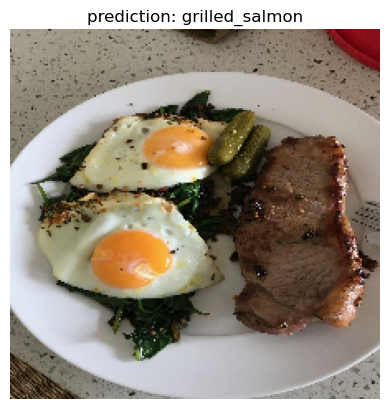

In [245]:
pred_and_plot(model10, steak)

### Saving and loading the model

In [247]:
model10.save('saved_trained_model10')

INFO:tensorflow:Assets written to: saved_trained_model10\assets


INFO:tensorflow:Assets written to: saved_trained_model10\assets


In [251]:
model10.save('saved_trained_model10.h5')

In [248]:
#load in a trained model and eval it
loaded_model10 = tf.keras.models.load_model('saved_trained_model10')
loaded_model10.evaluate(test_data)

79/79 [==============================] - 6s 79ms/step - loss: 1.8455 - accuracy: 0.3740


[1.8454570770263672, 0.37400001287460327]

In [249]:
model10.evaluate(test_data)

79/79 [==============================] - 6s 79ms/step - loss: 1.8455 - accuracy: 0.3740


[1.8454571962356567, 0.37400001287460327]

In [250]:
#these two should be exactly the same results if it's been saved correctly.

In [252]:
loaded_model10_h5 = tf.keras.models.load_model('saved_trained_model10.h5')
loaded_model10_h5.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 1.8455 - accuracy: 0.3740


[1.8454571962356567, 0.37400001287460327]